#NIFTY 50 : RAJESHEXPO STOCK PRICE PREDICTION
Final Assignment/Project for "Deep Learning: Zero to GANs" course by Medha Mathur.


In [2]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import numpy as np
import datetime as dt
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler

### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers import Dropout

In [5]:
sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [6]:
project_name='nifty-50-stock-price-prediction-rajeshexpo'

Dataset taken from :

https://in.finance.yahoo.com/quote/RAJESHEXPO.NS/history?period1=1262304000&period2=1609891200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

The .csv file has been imported in the from Google Sheets. 

In [7]:
!pip install jovian --upgrade -q

In [8]:
import jovian

In [9]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/medhamathur27/nifty-50-stock-price-prediction-rajeshexpo


'https://jovian.ai/medhamathur27/nifty-50-stock-price-prediction-rajeshexpo'

In [10]:
!pip install --upgrade gspread

  Found existing installation: gspread 3.0.1
    Uninstalling gspread-3.0.1:
      Successfully uninstalled gspread-3.0.1


In [11]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [12]:
worksheet = gc.open('RAJESHEXPO.csv').sheet1
rows = worksheet.get_all_values()
dataset_raw = pd.DataFrame(rows[1:],columns=rows[0])
dataset_raw.dropna()
dataset_raw.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,90.5,90.5,89,89.5,85.362877,909882
1,2010-01-05,90.5,93.099998,89.900002,92.400002,88.128822,1127613
2,2010-01-06,92.900002,96.400002,92.599998,93.349998,89.034927,1220917
3,2010-01-07,94.599998,97.050003,91.900002,94,89.654877,1410889
4,2010-01-08,94.199997,98,92.400002,92.800003,88.510338,1789177


In [13]:
dataset_raw.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2718,2020-12-30,492.899994,495.049988,481.299988,486.799988,486.799988,107848
2719,2020-12-31,499.649994,505,484,490.549988,490.549988,452244
2720,2021-01-01,492.799988,497,480.799988,485.049988,485.049988,211225
2721,2021-01-04,485.600006,487.950012,481.25,484,484,203133
2722,2021-01-05,481,487.700012,478,484.100006,484.100006,215378


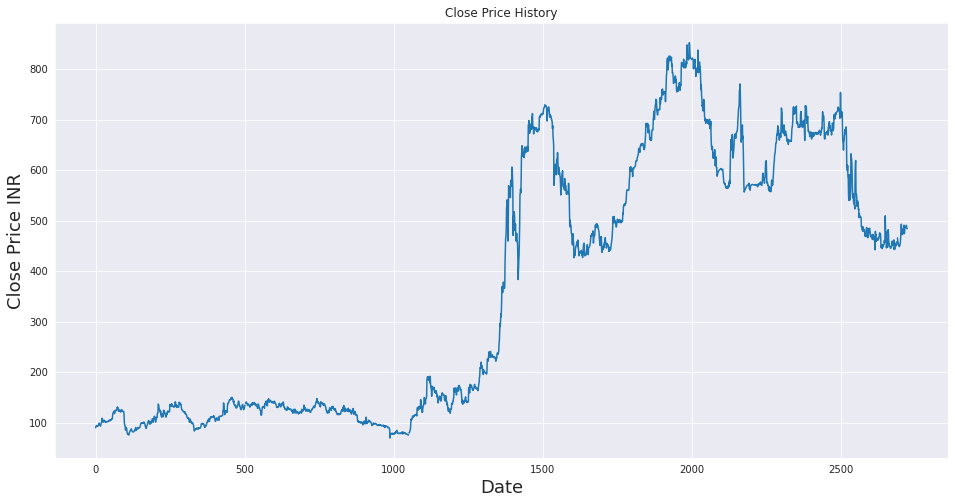

In [14]:
#Visualizing the closing price history for the training dataset
close_price = pd.to_numeric(dataset_raw['Close'], errors='coerce')
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(close_price)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price INR',fontsize=18)
plt.show()


In [15]:
features = ["Date", "Close"]
dataset = dataset_raw[features]

In [16]:
#setting index
dataset.index = dataset.Date
dataset.drop('Date', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [17]:
dataset.head()

,Close
Date,
2010-01-04,89.5
2010-01-05,92.400002
2010-01-06,93.349998
2010-01-07,94
2010-01-08,92.800003


In [18]:
dataset['Close'] = close_price.values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
dataset['Close'] = dataset['Close'].fillna(0)
dataset=dataset[dataset['Close'] != 0]

In [21]:
dataset.shape

(2714, 1)

#Preparing the dataset for Training

In [22]:
dataset_final = dataset.values
train_ds = dataset_final[0:1714,:]
valid_ds = dataset_final[1714:,:]

In [23]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset_final)

Creating Sliding Window of 90 days

In [24]:
x_train, y_train = [], []
for i in range(90,len(train_ds)):
    x_train.append(scaled_data[i-90:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [25]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [26]:
assert not np.any(np.isnan(x_train))

Model Building

In [140]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1),activation="relu"))
model.add(Dropout(rate = 0.0001))

model.add(LSTM(units=50, return_sequences = True,activation="relu"))
model.add(Dropout(rate = 0.0001))

model.add(LSTM(units=50, return_sequences = True,activation="relu"))
model.add(Dropout(rate = 0.0001))

model.add(LSTM(units=50, return_sequences = False,activation="relu"))
model.add(Dropout(rate = 0.0001))

model.add(Dense(1))

In [141]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [142]:
model.fit(x_train, y_train, epochs=25, batch_size=64)

Epoch 1/25
26/26 [==============================] - 10s 216ms/step - loss: 0.0801
Epoch 2/25
26/26 [==============================] - 7s 252ms/step - loss: 0.0106
Epoch 3/25
26/26 [==============================] - 6s 218ms/step - loss: 0.0024
Epoch 4/25
26/26 [==============================] - 6s 216ms/step - loss: 0.0016
Epoch 5/25
26/26 [==============================] - 5s 209ms/step - loss: 0.0015
Epoch 6/25
26/26 [==============================] - 5s 211ms/step - loss: 0.0012
Epoch 7/25
26/26 [==============================] - 5s 210ms/step - loss: 0.0015
Epoch 8/25
26/26 [==============================] - 5s 211ms/step - loss: 0.0013
Epoch 9/25
26/26 [==============================] - 6s 212ms/step - loss: 0.0012
Epoch 10/25
26/26 [==============================] - 5s 210ms/step - loss: 0.0013
Epoch 11/25
26/26 [==============================] - 6s 211ms/step - loss: 0.0010
Epoch 12/25
26/26 [==============================] - 6s 212ms/step - loss: 0.0012
Epoch 13/25
26/26 [=====

In [143]:
model.fit(x_train, y_train, epochs=25, batch_size=64)

Epoch 1/25
26/26 [==============================] - 6s 213ms/step - loss: 6.8460e-04
Epoch 2/25
26/26 [==============================] - 6s 213ms/step - loss: 6.3805e-04
Epoch 3/25
26/26 [==============================] - 6s 215ms/step - loss: 8.6183e-04
Epoch 4/25
26/26 [==============================] - 6s 215ms/step - loss: 6.5623e-04
Epoch 5/25
26/26 [==============================] - 6s 216ms/step - loss: 5.6658e-04
Epoch 6/25
26/26 [==============================] - 6s 215ms/step - loss: 6.3574e-04
Epoch 7/25
26/26 [==============================] - 6s 215ms/step - loss: 5.1557e-04
Epoch 8/25
26/26 [==============================] - 6s 214ms/step - loss: 5.1617e-04
Epoch 9/25
26/26 [==============================] - 6s 216ms/step - loss: 5.2868e-04
Epoch 10/25
26/26 [==============================] - 6s 217ms/step - loss: 4.9507e-04
Epoch 11/25
26/26 [==============================] - 6s 218ms/step - loss: 6.0849e-04
Epoch 12/25
26/26 [==============================] - 6s 216ms/s

In [144]:
model.fit(x_train, y_train, epochs=25, batch_size=64)

Epoch 1/25
26/26 [==============================] - 6s 216ms/step - loss: 3.6948e-04
Epoch 2/25
26/26 [==============================] - 6s 220ms/step - loss: 3.5669e-04
Epoch 3/25
26/26 [==============================] - 6s 216ms/step - loss: 4.0801e-04
Epoch 4/25
26/26 [==============================] - 6s 216ms/step - loss: 3.5102e-04
Epoch 5/25
26/26 [==============================] - 6s 215ms/step - loss: 3.4299e-04
Epoch 6/25
26/26 [==============================] - 6s 216ms/step - loss: 3.2547e-04
Epoch 7/25
26/26 [==============================] - 6s 216ms/step - loss: 3.2570e-04
Epoch 8/25
26/26 [==============================] - 6s 216ms/step - loss: 3.3160e-04
Epoch 9/25
26/26 [==============================] - 6s 218ms/step - loss: 4.4370e-04
Epoch 10/25
26/26 [==============================] - 6s 218ms/step - loss: 3.9167e-04
Epoch 11/25
26/26 [==============================] - 6s 219ms/step - loss: 3.1422e-04
Epoch 12/25
26/26 [==============================] - 6s 223ms/s

In [155]:
model.fit(x_train, y_train, epochs=25, batch_size=55)

Epoch 1/25
30/30 [==============================] - 6s 207ms/step - loss: 3.3363e-04
Epoch 2/25
30/30 [==============================] - 6s 206ms/step - loss: 2.8967e-04
Epoch 3/25
30/30 [==============================] - 6s 205ms/step - loss: 2.3163e-04
Epoch 4/25
30/30 [==============================] - 6s 210ms/step - loss: 2.2926e-04
Epoch 5/25
30/30 [==============================] - 6s 208ms/step - loss: 2.7336e-04
Epoch 6/25
30/30 [==============================] - 6s 210ms/step - loss: 2.8118e-04
Epoch 7/25
30/30 [==============================] - 6s 205ms/step - loss: 3.0113e-04
Epoch 8/25
30/30 [==============================] - 6s 205ms/step - loss: 2.7133e-04
Epoch 9/25
30/30 [==============================] - 6s 208ms/step - loss: 2.5184e-04
Epoch 10/25
30/30 [==============================] - 6s 205ms/step - loss: 2.4410e-04
Epoch 11/25
30/30 [==============================] - 6s 207ms/step - loss: 2.1568e-04
Epoch 12/25
30/30 [==============================] - 6s 206ms/s

In [176]:
#predicting test data values, using past 90 from the train data
inputs = dataset[len(dataset) - len(valid_ds)-90:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [146]:
inputs.shape

(1090, 1)

In [177]:
X_test = []
for i in range(90,inputs.shape[0]):
    X_test.append(inputs[i-90:i,0])
X_test = np.array(X_test)

In [158]:
X_test

array([[0.46238343, 0.46359688, 0.45650783, ..., 0.48856813, 0.48703535,
        0.48448075],
       [0.46359688, 0.45650783, 0.46263891, ..., 0.48703535, 0.48448075,
        0.47234637],
       [0.45650783, 0.46263891, 0.47355983, ..., 0.48448075, 0.47234637,
        0.47458165],
       ...,
       [0.51896791, 0.51877632, 0.51654104, ..., 0.53257121, 0.53333756,
        0.53812744],
       [0.51877632, 0.51654104, 0.51679652, ..., 0.53333756, 0.53812744,
        0.53110228],
       [0.51654104, 0.51679652, 0.50542853, ..., 0.53812744, 0.53110228,
        0.52976113]])

In [149]:
X_test.shape

(1000, 90)

In [178]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds)

In [151]:
X_test.shape

(1000, 90, 1)

In [179]:
preds

array([[457.34726],
       [452.74503],
       [449.12604],
       [446.82718],
       [448.57993],
       [450.31003],
       [450.49802],
       [450.306  ],
       [451.94977],
       [455.24634],
       [460.30402],
       [465.48114],
       [470.55246],
       [477.49115],
       [486.52917],
       [500.75754],
       [510.45996],
       [510.70135],
       [510.98788],
       [512.4448 ],
       [510.40747],
       [507.40063],
       [505.25754],
       [501.7072 ],
       [499.94876],
       [499.01984],
       [495.30643],
       [493.25272],
       [496.007  ],
       [499.9108 ],
       [504.1239 ],
       [504.5674 ],
       [503.83875],
       [503.53183],
       [503.54654],
       [502.31778],
       [503.79764],
       [505.62155],
       [505.17908],
       [503.859  ],
       [502.28738],
       [503.33817],
       [503.10098],
       [502.0906 ],
       [502.10678],
       [502.8424 ],
       [503.45352],
       [504.28262],
       [511.78915],
       [517.08887],


In [180]:
rms=np.sqrt(np.mean(np.power((valid_ds-preds),2)))
rms

13.917788795554515

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


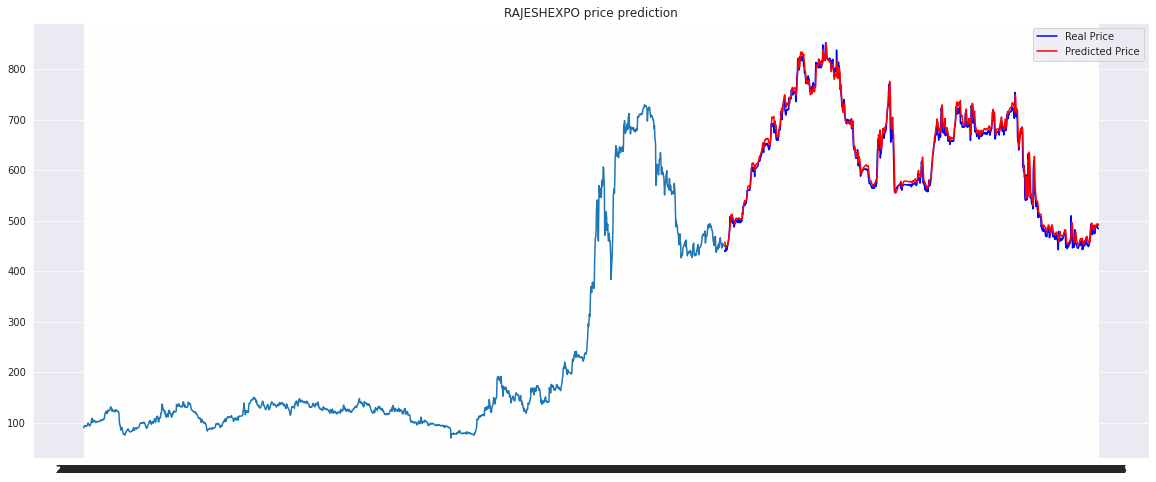

In [162]:
#for plotting
train = dataset[0:1714]
valid = dataset[1714:]
valid['Predictions'] = preds
plt.figure(figsize=(20,8))
plt.plot(train['Close'])
plt.plot(valid['Close'], color = 'blue', label = 'Real Price')
plt.plot(valid['Predictions'], color = 'red', label = 'Predicted Price')
plt.title('RAJESHEXPO price prediction')
plt.legend()
plt.show()

#Predicting future value of stock

In [212]:
look_back=30
inputs = dataset[-look_back:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [213]:
forecast_list=[]
for _ in range(30):
  x = inputs[-look_back:]
  x = np.reshape(x, (x.shape[1],x.shape[0],1))
  forecast = model.predict(x)
  forecast = scaler.inverse_transform(forecast)
  inputs = scaler.inverse_transform(inputs)
  inputs = np.append(inputs,forecast[0][0])
  inputs = inputs.reshape(-1,1)
  inputs  = scaler.transform(inputs)
  forecast_list.append(forecast[0][0])

In [209]:
last_date = dataset_raw['Date'].values[-1]
prediction_dates = pd.date_range(last_date, periods=31).tolist()
prediction_dates = prediction_dates[1:]
prediction_dates

[Timestamp('2021-01-06 00:00:00', freq='D'),
 Timestamp('2021-01-07 00:00:00', freq='D'),
 Timestamp('2021-01-08 00:00:00', freq='D'),
 Timestamp('2021-01-09 00:00:00', freq='D'),
 Timestamp('2021-01-10 00:00:00', freq='D'),
 Timestamp('2021-01-11 00:00:00', freq='D'),
 Timestamp('2021-01-12 00:00:00', freq='D'),
 Timestamp('2021-01-13 00:00:00', freq='D'),
 Timestamp('2021-01-14 00:00:00', freq='D'),
 Timestamp('2021-01-15 00:00:00', freq='D'),
 Timestamp('2021-01-16 00:00:00', freq='D'),
 Timestamp('2021-01-17 00:00:00', freq='D'),
 Timestamp('2021-01-18 00:00:00', freq='D'),
 Timestamp('2021-01-19 00:00:00', freq='D'),
 Timestamp('2021-01-20 00:00:00', freq='D'),
 Timestamp('2021-01-21 00:00:00', freq='D'),
 Timestamp('2021-01-22 00:00:00', freq='D'),
 Timestamp('2021-01-23 00:00:00', freq='D'),
 Timestamp('2021-01-24 00:00:00', freq='D'),
 Timestamp('2021-01-25 00:00:00', freq='D'),
 Timestamp('2021-01-26 00:00:00', freq='D'),
 Timestamp('2021-01-27 00:00:00', freq='D'),
 Timestamp

In [214]:
fpred=pd.DataFrame(list(zip(prediction_dates, forecast_list)), 
               columns =['Date', 'Predicted Close']) 
fpred

,Date,Predicted Close
0,2021-01-06,487.185303
1,2021-01-07,487.496674
2,2021-01-08,488.313049
3,2021-01-09,488.993744
4,2021-01-10,489.385956
5,2021-01-11,489.479706
6,2021-01-12,489.295197
7,2021-01-13,488.859497
8,2021-01-14,488.352661
9,2021-01-15,487.794098


<Figure size 648x360 with 0 Axes>

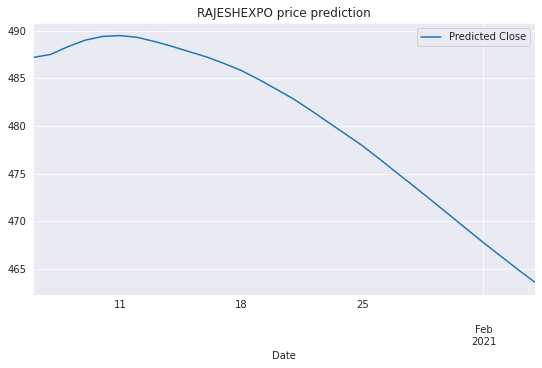

In [215]:
plt.figure(figsize=(9,5))
fpred.plot(x='Date',label = 'Predicted Price')
plt.title('RAJESHEXPO price prediction')
plt.legend()
plt.show()

In [191]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/medhamathur27/nifty-50-stock-price-prediction-rajeshexpo


'https://jovian.ai/medhamathur27/nifty-50-stock-price-prediction-rajeshexpo'